In [1]:
import pandas as pd
import random
import itertools
import datetime as dt
import matplotlib.pyplot as plt
import calendar
import numpy as np
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('pared_turnstile.csv', low_memory=False)

In [5]:
df['DATETIME'] = pd.to_datetime(df['DATETIME'], format='%Y-%m-%d %H:%M:%S')
df['TOTAL'] = df['ENTRY_DIFFS'] + df['EXIT_DIFFS']
df['DAY_OF_WEEK'] = df['DATETIME'].dt.weekday
df.set_index('DATETIME', inplace=True)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

Resample dataframe every 4 hours:

In [6]:
df2 = df.groupby(['STATION']).resample(rule='4H').sum().reset_index()

In [7]:
# Day of Week gets summed because it's a number. Re-compute
df2['DAY_OF_WEEK'] = df2['DATETIME'].dt.weekday
df2['DATE'] = df2['DATETIME'].dt.date
df2['TIME'] = df2['DATETIME'].dt.time
df2.drop(['ENTRIES','EXITS'], axis=1, inplace=True)

In [8]:
d_vs_e = ['wkday']*5 + ['wkend']*2
wkday_wkend_dict = dict(zip(range(7), d_vs_e))
df2['WKDAY_WKEND'] = df2['DAY_OF_WEEK'].map(wkday_wkend_dict)

In [ ]:
# If you need to re-save csv file, un-silence this.
# df2.to_csv('resampled_turnstile_data.csv')

### Group-by's

In [9]:
grp1 = df2.groupby(['STATION', 'DAY_OF_WEEK'])['TOTAL'].mean().reset_index()

In [10]:
grp2 = df2.groupby(['STATION'])['TOTAL'].sum().reset_index()

In [11]:
grp22 = df2.groupby(['STATION','DATE'])['TOTAL'].sum().reset_index()
grp23 = grp22.groupby('STATION')['TOTAL'].median().reset_index()

In [12]:
grp3 = df2.groupby(['STATION','DATE'])['TOTAL'].sum().reset_index()

In [13]:
grp4 = df2.groupby(['STATION','WKDAY_WKEND'])['TOTAL'].std().unstack()

In [14]:
grp5 = df2.groupby(['STATION','WKDAY_WKEND'])['TOTAL'].sum().unstack()
grp5['WKEND_DIFF'] = grp5['wkday'] - grp5['wkend']
# grp5.sort_values('WKEND_DIFF').head()

Merge these df's to compile these data with TOTAL volume

In [15]:
grp6 = pd.merge(grp2, grp4, on='STATION')
grp6 = pd.merge(grp6, grp5, on='STATION')
grp6.rename(columns={'wkday_x':'WKDAY_std', 'wkend_x':'WKEND_std', 
                     'wkday_y':'WKDAY_TOTAL','wkend_y':'WKEND_TOTAL'}, 
            inplace=True)

In [16]:
grp6['WKEND_DIFF%'] = grp6['WKEND_DIFF'] / grp6['TOTAL']
grp6['WKEND%'] = grp6['WKEND_TOTAL'] / grp6['TOTAL']
grp6['WKDAY_rsd'] = grp6['WKDAY_std'] / grp6['TOTAL']

Drop any entries for which the Weekend total is low -- likely this station was closed due to track work

In [17]:
grp6 = grp6.drop(grp6[grp6['WKEND_TOTAL'] < 500].index)
grp6['WEEKDAY_RATIO'] = (grp6['WKDAY_TOTAL']/5) / (grp6['WKEND_TOTAL']/2)

### Generate some datasets 

To aid in EDA. High, mid, low volume; a random subset; top-50

In [18]:
highest_vol = list(set(grp2.sort_values('TOTAL').tail(16)['STATION']))
lowest_vol = list(set(grp2.sort_values('TOTAL').head(16)['STATION']))
rand_vol = list(set(grp2.sort_values('TOTAL').sample(16)['STATION']))

n = len(grp2)
mid_vol = list(set(grp2.sort_values('TOTAL').iloc[(n//2)-8:(n//2)+8]['STATION']))

top50 = grp6.sort_values('TOTAL', ascending=False).head(50)

## Teasing out Commuter vs. Tourist stations

Commuter station likely to:
- have consistent weekday traffic --> low RSD (relative std dev) of weekday traffic
- have low relative weekend traffic

Tourist stations likely to:
- small(er) difference between weekday & weekend traffic
    - high % weekend traffic
    - high weekday:weekend ratio
- be more chaotic --> high overall std dev

### Lists

Stations with most consistent weekday traffic (lowest Weekday rsd)

In [19]:
low_wkday_rsd = grp6.sort_values('WKDAY_rsd').head(15)[['STATION', 'TOTAL', 'WKDAY_rsd']]

Stations with low weekend % (filtered for a minimum total volume)

In [20]:
low_wkend_pct = grp6[grp6['TOTAL'] > 10000].sort_values('WKEND%').head(15)[['STATION', 'TOTAL', 'WKEND%']]

Stations with high weekend % (filtered for a minimum total volume)

In [22]:
high_wkend_pct = (grp6[grp6['TOTAL'] > 10000]
                  .sort_values('WKEND%', ascending=False)
                  .head(15)[['STATION', 'TOTAL', 'WKEND%']])

### Line charts

Plot all days in dataset: To make sure there are no anomalies on a certain day

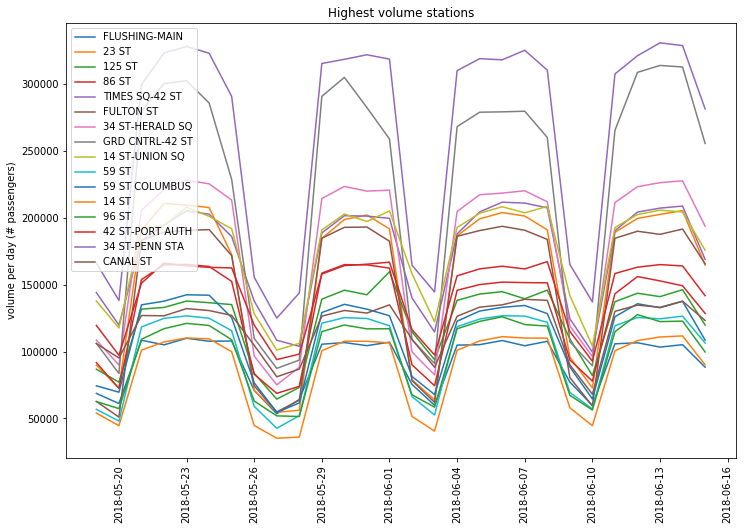

In [30]:
# ** If we want to keep this chart, change x-axis to 'Mon, Tues, Wed, etc'?

fig, ax = plt.subplots(figsize=[12,8])

for s in highest_vol:
    dum_df = grp3[grp3['STATION'] == s]
    xs = dum_df['DATE']
    plt.plot(xs, dum_df['TOTAL'], label=s)
#     xticklocs = ax.get_xticks()
#     plt.xticks(xticklocs, x_labels)
    plt.xticks(rotation=90)
    plt.legend()
    plt.ylabel('volume per day (# passengers)')
    plt.title('Highest volume stations');

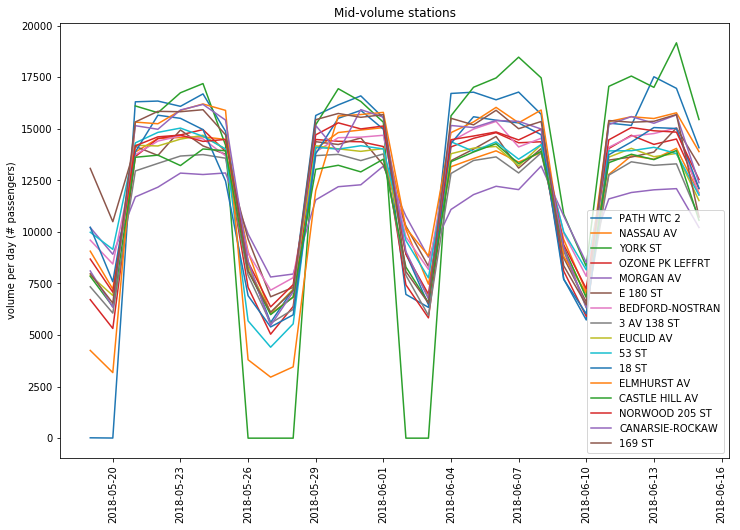

In [31]:
# ** If we want to keep this chart, change x-axis to 'Mon, Tues, Wed, etc'?

fig, ax = plt.subplots(figsize=[12,8])

for s in mid_vol:
    dum_df = grp3[grp3['STATION'] == s]
    xs = dum_df['DATE']
    plt.plot(xs, dum_df['TOTAL'], label=s)
#     xticklocs = ax.get_xticks()
#     plt.xticks(xticklocs, x_labels)
    plt.xticks(rotation=90)
    plt.legend()
    plt.ylabel('volume per day (# passengers)')
    plt.title('Mid-volume stations');

York St appears closed on weekend (volume = 0)

**Average by Day of week**

In [32]:
xlabels_dow = calendar.day_name[:]

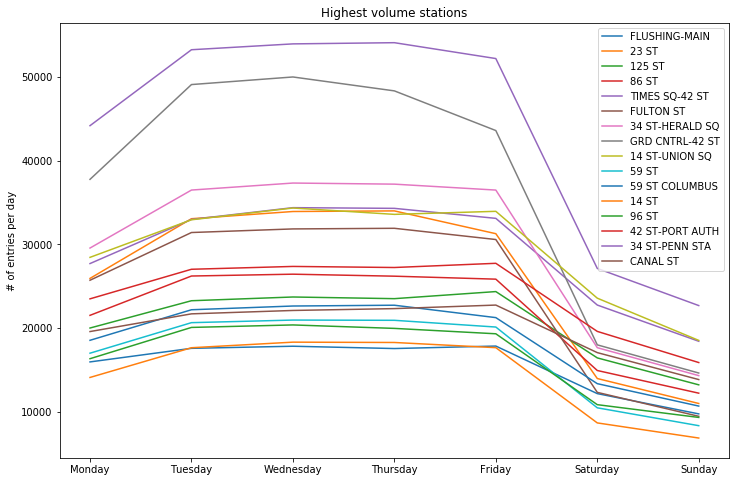

In [34]:
fig, ax = plt.subplots(figsize=[12,8])

for s in highest_vol:
    dum_df = grp1[grp1['STATION'] == s]
    xs = dum_df['DAY_OF_WEEK']
    plt.plot(xs, dum_df['TOTAL'], label=s)

plt.xticks(np.arange(7), xlabels_dow)
plt.legend()
plt.ylabel('# of entries per day')
plt.title('Highest volume stations');

Weekday ridership is consistent and high at "high volume" stations.

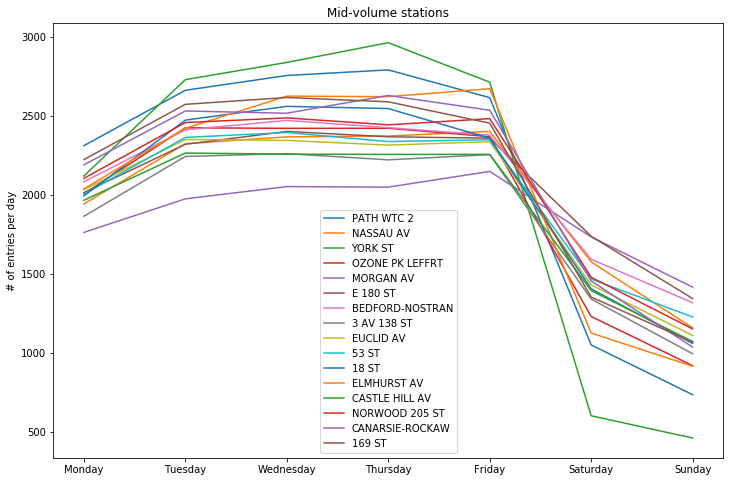

In [35]:
fig, ax = plt.subplots(figsize=[12,8])

for s in mid_vol:
    dum_df = grp1[grp1['STATION'] == s]
    xs = dum_df['DAY_OF_WEEK']
    plt.plot(xs, dum_df['TOTAL'], label=s)

plt.xticks(np.arange(7), xlabels_dow)
plt.legend()
plt.ylabel('# of entries per day')
plt.title('Mid-volume stations');

### Histograms

In [38]:
grp6.head()

,STATION,TOTAL,WKDAY_std,WKEND_std,WKDAY_TOTAL,WKEND_TOTAL,WKEND_DIFF,WKEND_DIFF%,WKEND%,WKDAY_rsd,WEEKDAY_RATIO
0,1 AV,1196487.0,4200.039851,3197.111222,918749.0,277738.0,641011.0,0.535744,0.232128,0.003510,1.323188
1,103 ST,1348643.0,5222.886262,2872.175267,1109699.0,238944.0,870755.0,0.645653,0.177174,0.003873,1.857672
2,103 ST-CORONA,868706.0,2569.509990,1521.139438,681099.0,187607.0,493492.0,0.568077,0.215961,0.002958,1.452182
3,104 ST,103917.0,427.165616,156.746713,87381.0,16536.0,70845.0,0.681746,0.159127,0.004111,2.113716
4,110 ST,510113.0,1844.339882,1148.413614,409387.0,100726.0,308661.0,0.605084,0.197458,0.003616,1.625745


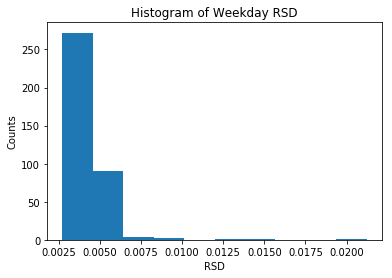

In [40]:
plt.hist(grp6['WKDAY_rsd'])
plt.xlabel('RSD')
plt.ylabel('Counts')
plt.title('Histogram of Weekday RSD');

Many stations have low-weekday RSD (relative stdev). This may not be a useful criteria

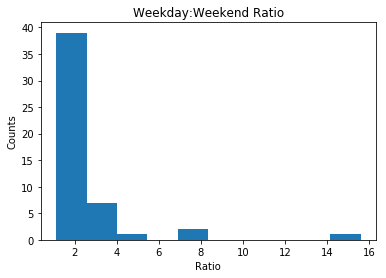

In [41]:
plt.hist(top50['WEEKDAY_RATIO'])
plt.xlabel('Ratio')
plt.ylabel('Counts')
plt.title('Weekday:Weekend Ratio');

Weekday-weekend ratio could be a useful criterion.

### Scatter Plots

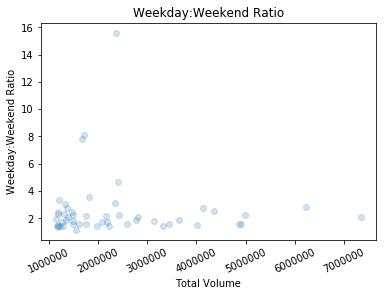

In [42]:
plt.scatter(top50['TOTAL'],top50['WEEKDAY_RATIO'], alpha=0.2)
plt.xlabel('Total Volume')
plt.ylabel('Weekday:Weekend Ratio')
plt.xticks(rotation=25)
plt.title('Weekday:Weekend Ratio');

Most high-volume stations have a low weekday-weekend ratio -- indicating they are "tourist" stations.

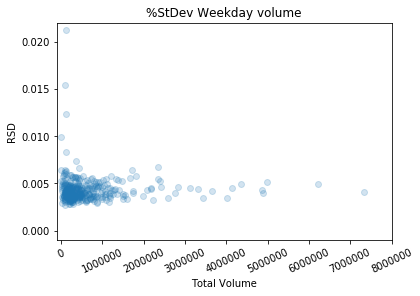

In [60]:
plt.scatter(grp6['TOTAL'],grp6['WKDAY_rsd'], alpha=0.2)
plt.xlabel('Total Volume')
plt.ylabel('RSD')
plt.axis([-100000, 8000000, -0.001, 0.022])
plt.xticks(rotation=25)
plt.title('%StDev Weekday volume');

Most high-voluem stations have low weekday RSD.

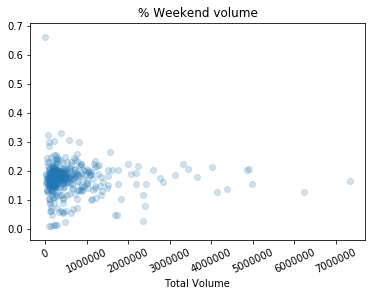

In [62]:
plt.scatter(grp6['TOTAL'],grp6['WKEND%'], alpha=0.2)
plt.xlabel('Total Volume')
# plt.ylabel('RSD')
# plt.axis([-100000, 8000000, -0.001, 0.03])
plt.xticks(rotation=25)
plt.title('% Weekend volume');

MOst high-volume stations have low % weekend volume. (Not a useful criterion.)

### Pair Plots

In [63]:
pp_df = grp6[['STATION','TOTAL','WKEND%','WKDAY_rsd']]

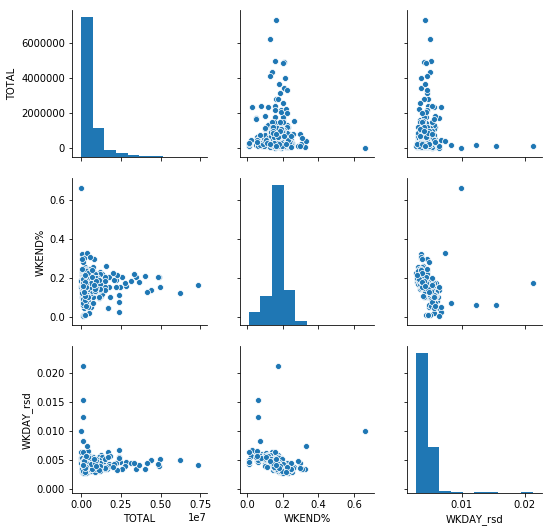

In [64]:
plt.figsize=[20,20]
sns.pairplot(pp_df)

This doesn't show much

### Volume by 4-hr time slice

What stations experience the top volume in a 4-hr period?

Play with # in head() to get desired # of stations

In [65]:
top_vol_4hr = list(set(df2.sort_values('TOTAL', ascending=False).head(400)['STATION']))

The same stations have highest volume within a 4-hour period and summed over a month:

In [66]:
top_vol_4hr.sort() == highest_vol.sort()

True

Histogram of 4-hr volumes. (Magnitude of # of people they can reach)

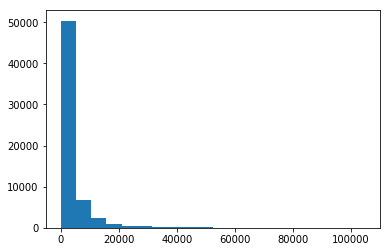

In [67]:
plt.hist(df2['TOTAL'], bins=20);